# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# Install library missingno for na's analysis
! pip install missingno

In [2]:
# Install library progressbar2 to display the progress of a long 
# running operation, providing a visual cue that processing is underway.

! pip install progressbar2

### Libraries 

To get started, let’s import the required libraries into our Python environment. 

In [3]:
# Libraries

import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import missingno as msno
import progressbar
from datetime import date
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

% matplotlib inline
sns.set(style = 'whitegrid')
pd.options.display.max_columns = None

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
## Functions created for exploration analysis
## -----------------------------------------------

def plot_profile(df, variable):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plt - basic histogram and density plot
    
    ''' 
    sns.set(style = 'whitegrid', font_scale = 1.25)
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)
    
    plt.sca(ax[0])
    sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
    plt.title('Female\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.distplot(df[df['gender'] == 'M'][variable], bins = 10, color = palette[1]);
    plt.title('Male\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')

    plt.sca(ax[2])
    sns.distplot(df[df['gender'] == 'O'][variable], bins = 10, color = palette[2]);
    plt.title('Other\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.show()
    
    return plt

def plot_profile_general(df, var1,var2, var3):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    var1, var2 - the variable to be plotted
    
    OUTPUT:
    plt - basic histogram and density plot
    
    ''' 
    sns.set(style = 'whitegrid', font_scale = 1.25)
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = False, sharey = False)

    plt.sca(ax[0])
    sns.distplot(df[var1], bins = 10, color = palette[4]);
    plt.title('Age\'s distribution')
    plt.xlabel(f'{var1}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.distplot(df[var2].dropna(),  bins = 10, color = palette[5]);
    plt.title('Income\'s distribution')
    plt.xlabel(f'{var2}')
    
    plt.sca(ax[2])
    df[var3].value_counts().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color=palette[3]);
    plt.title('Gender\'s distribution');
    plt.xlabel(f'{var3}');
    plt.grid();
    
    return plt

## -----------------------------------------------
## Function created for Data manipulation modeling
## -----------------------------------------------

def Create_Labels(profile, portfolio, transcript):
    
    '''
    Function that creates success labels when a customer completes the entire 
    transaction process. That is, the customer received, viewed and completed 
    the offer.
    
    Params:
    profile:  profile.json data set
    portfolio: portfolio.json data set
    transcript: transcript.json data set
    
    Output:
    data:  a union of all datasets with an extra column 'offer_success' which will be the target variable 
    for the model.
    
    '''
    data = []
    
    # new time based variable
    transcript['time_days'] = transcript['time']/24
    
    # subset of groups of transacction and offers.
    offers_df = transcript[transcript['event_transaction']!=1]
    transaction_df = transcript[transcript['event_transaction']==1]
    
    # one-hot encode offer event
    offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer_received' else 0)
    offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer_completed' else 0)
    offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer_viewed' else 0)
    offers_df.drop(columns=['event', 'amount'], inplace=True)
    
    # manipulating data set
    transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
    
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']

            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]

            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]

            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time_days']
            end_time = start_time + duration_days

            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time_days'] >= start_time, offer_completed_data['time_days'] <= end_time)

            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time_days'] >= start_time, offer_viewed_data['time_days'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0

            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time_days'] >= start_time, cust_transaction_data['time_days'] <= end_time)

            transaction_data = cust_transaction_data[transaction_withintime]

            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()

            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time_days': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
            
            row.update(offer_row.iloc[0,0:].to_dict())
            
            if not customer.empty:
                row.update(customer.iloc[0,:].to_dict())
            rows.append(row)
            
        data.extend(rows)
        
    data = pd.DataFrame(data)
    return data

# Data Exploration

We are going to explore the information of each of the project's datasets

## (a) Portfolio data 

In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [7]:
print(f"There are {portfolio['id'].nunique()} unique offers in the portfolio.")
print("These are distributed among the offer types as follows")
portfolio.offer_type.value_counts()

There are 10 unique offers in the portfolio.
These are distributed among the offer types as follows


bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In order to extract valuable information of actual dataset, it is necessary to made the next transformations:<br>
- create dummies for channels <br>
- create dummies for offer type <br>
- change id column name to offer_id<br>

In [8]:
# clean channels and offer types
channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
offer_types = pd.get_dummies(portfolio.offer_type)
portfolio = pd.concat([portfolio, channels, offer_types], axis=1)
portfolio.drop(['channels'], axis=1, inplace=True)

# rename id by offer_id
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


## (b) Profile data 

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
# Summary statistics provide valuable insights into the distribution, central tendency, and variability of our data.
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Transformations needed:<br>
- Delete row nulls <br>
- Convert became_member_on into datatime <br>
- Create a variable with the membership duration <br>
- Create a variable with the difference in days with the oldest member
- Rename the column id by customer_id <br>

### Check for missing values in the dataset
Missing values can affect the accuracy and reliability of our analysis. Let’s check if there are any missing values in our dataset.

In [12]:
# Percentaje of null values
profile.isnull().sum()*100/len(profile)

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

As we saw in the descriptive statistics, there is a high concentration of ages with 118 years old. Let's see if it has an important explanation.

Text(0,0.5,'Distribution')

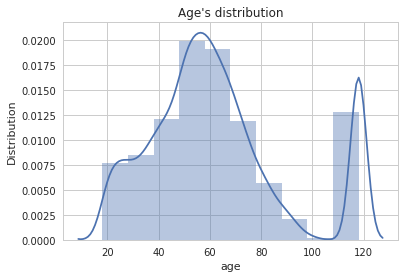

In [13]:
# Age's Distribution 

sns.distplot(profile['age'], bins = 10);
plt.title('Age\'s distribution')
plt.ylabel('Distribution')

In [14]:
profile[profile['age'] == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [15]:
(profile[profile['age'] == 118]['age'].count()/len(profile))*100

12.794117647058822

2175 rows with missing values encoding as 118 age which correspond with 12,79% of NAs. <br>
It means that the fields: age, gender and income have the same missing information related for a particular customer_id

In [16]:
profile[profile['age'] == 118].head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


It is interesting to see that for every missing value in ´age´ column, set as 118. Both, the income and gender is also unknown. 
The total percentage of null values is 12.8%, as this is less percentage, my strategy is to drop those for the machine learning model.

In [17]:
# Deleting null values
profile.dropna(inplace=True)

In [18]:
# Calculate membership duration
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['membership_duration'] = (datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days
profile.head(7)

,age,became_member_on,gender,id,income,membership_duration
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2409
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2476
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2124
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2200
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2290
13,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2351
14,26,2014-02-13,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,3657


In [19]:
# Calculate diference with the oldest member 
profile['diff_oldest_member'] = profile['became_member_on'].apply(lambda x: x - profile['became_member_on'].min())

# Other tuning on data
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[6:7]))

In [20]:
# Rename the column id by customer_id
profile = profile.rename(columns = {'id': 'customer_id'})

We might also be interested in knowing how membership is increasing every year. </br>
So lets plot a line graph to see number of membership every year.

Text(0.5,1,'Number of members by year')

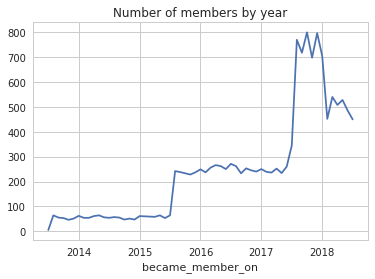

In [21]:
# Time series number of members by year
figsize=(20,4)
profile.groupby(profile['became_member_on'].dt.to_period('M'))['customer_id'].count().plot.line()
plt.title('Number of members by year')

Eventually, peaks have been recorded with a higher number of users every year, such as those that occurred in mid-2015 and 2017. It would be interesting to know what strategies/phenomena were developed that caused a direct increase in the number of users.

We also could be interested in knowing the distribution of the different variables as singular and desagregate by gender.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

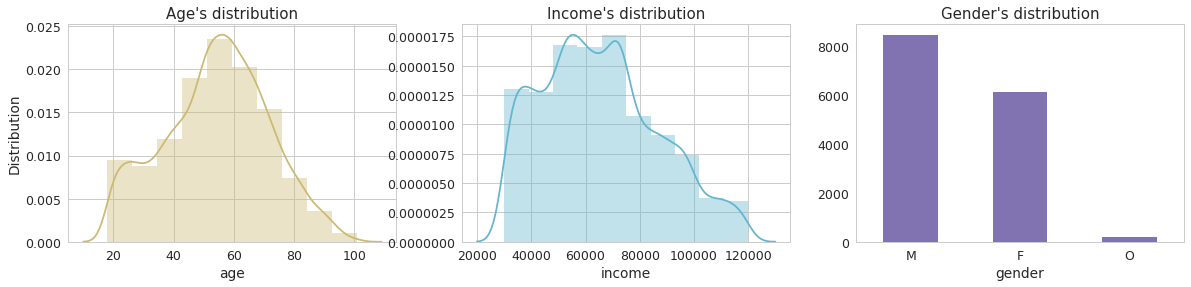

In [22]:
# Distribution of age and income
plot_profile_general(profile, 'age','income','gender')

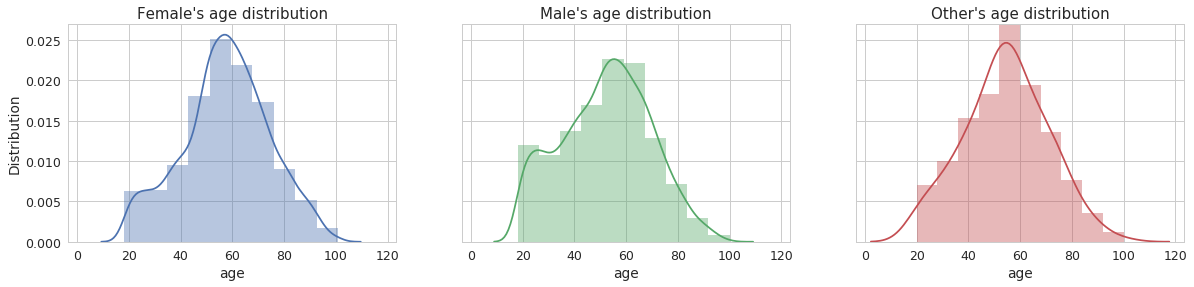

In [23]:
# Distribution of age, income, membership_duration by Gender.
age_plot = plot_profile(profile, 'age')

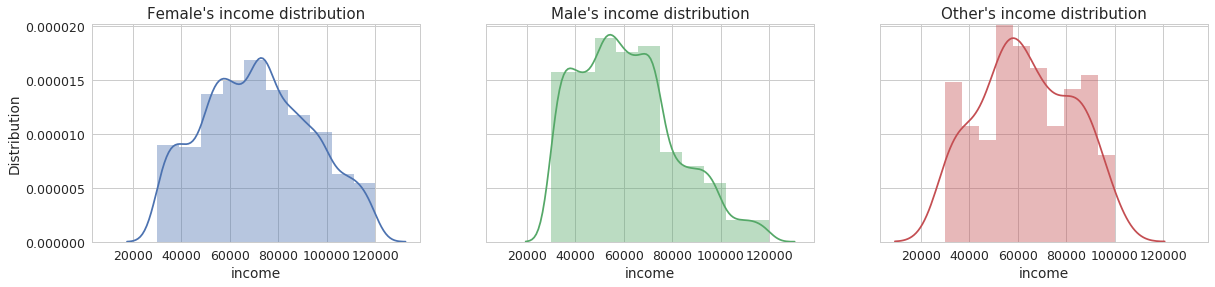

In [24]:
income_plot = plot_profile(profile, 'income')

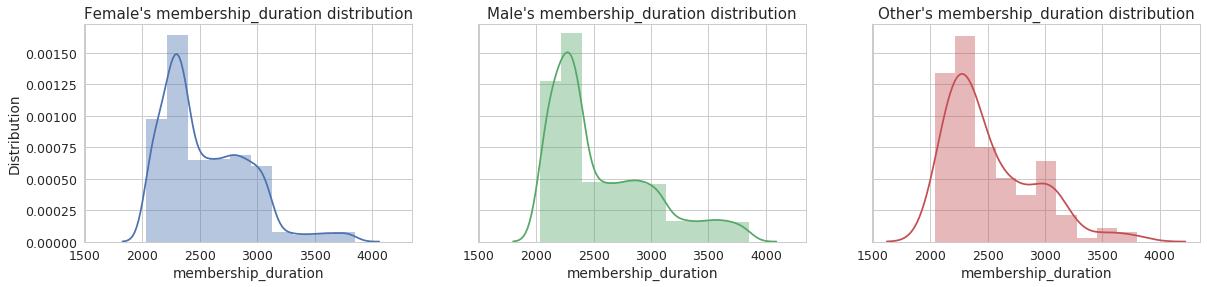

In [25]:
membership_duration_plot = plot_profile(profile, 'membership_duration')

- It seems to has a greater concentration of young men between 20-40 years old, unlike women where their concentration is greater at ages over 50 years old. <br>
- Regarding the distribution of income for the other gender, there is a greater difference in salary range in what seems to be based on 3 main ranges: 40,000 - 60,000 and 90,000 dollars. For male's income, there is a distribution with positive asymmetry and for female's income, there is apparently a normal distribution. <br>
- The membership duration mode is apparently around 2000 - 2500 days (6,849 years)

In [26]:
# Create dummy by gender
dummy_gender = pd.get_dummies(profile.gender, prefix="gender") 

In [27]:
profile = pd.concat([profile, dummy_gender], axis=1)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 12 columns):
age                    14825 non-null int64
became_member_on       14825 non-null datetime64[ns]
gender                 14825 non-null object
customer_id            14825 non-null object
income                 14825 non-null float64
membership_duration    14825 non-null int64
diff_oldest_member     14825 non-null timedelta64[ns]
member_year            14825 non-null int64
member_month           14825 non-null int64
gender_F               14825 non-null uint8
gender_M               14825 non-null uint8
gender_O               14825 non-null uint8
dtypes: datetime64[ns](1), float64(1), int64(4), object(2), timedelta64[ns](1), uint8(3)
memory usage: 1.2+ MB


### (c) Transcript data 

In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [30]:
# unique events types
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [31]:
# number of each events
events_table = transcript['event'].value_counts()
events_table

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

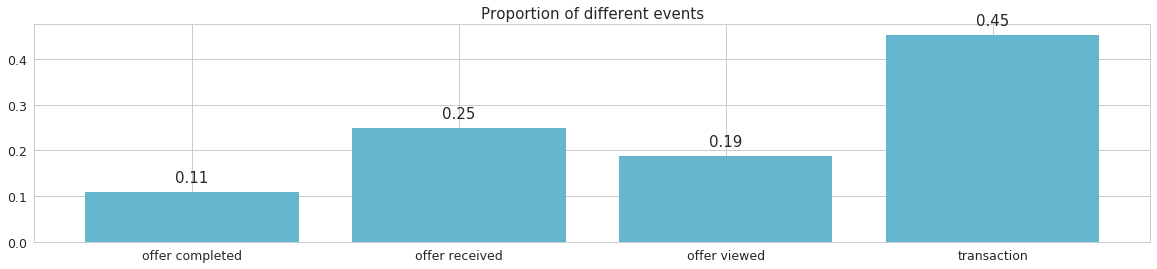

In [32]:
# number of each events
fig, ax = plt.subplots(figsize=(20,4))
sns.set(style = 'whitegrid', font_scale = 1.25)
palette = sns.color_palette()

bar = plt.bar(x = events_table.index, height = events_table/len(transcript['event']), color = palette[5])
plt.title('Proportion of different events')

for x,y in zip(events_table.index,events_table/len(transcript['event'])):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [33]:
# Variable manipulation
transcript['event'] = transcript.event.str.replace(' ', '_')

In [34]:
# Create dummy by event variable
dummy_event = pd.get_dummies(transcript.event, prefix="event")

In [35]:
# Get the offer_id, amount and reward data from the value column
transcript_values = transcript['value'].apply(pd.Series)
transcript_values.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [36]:
transcript_values.isna().sum()

offer id    172532
amount      167581
offer_id    272955
reward      272955
dtype: int64

In [ ]:
# Forma alterna
# value_dict = transcript['value'].to_dict()
# value_df = pd.DataFrame.from_dict(value_dict, orient='index')
# value_df

Two columns were found with the same name 'offer id' and 'offer_id', where the first contains the most information

In [37]:
# Imputing the na's values of 'offer id'
transcript_values['offer id'] = np.where(transcript_values['offer id'].isna() == True, transcript_values['offer_id'], transcript_values['offer id'])

In [38]:
# Delete the 2nd variable and rename by 'offer_id'
transcript_values.drop(columns=['offer_id'], inplace = True) 
transcript_values.rename(columns={"offer id": "offer_id"}, inplace= True)

In [39]:
# Delete value column
transcript.drop(columns=['value'], inplace = True)

In [40]:
# Consolidating the new clean dataset 
transcript_clean = pd.concat([transcript, dummy_event, transcript_values], axis=1) 
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 10 columns):
event                    306534 non-null object
person                   306534 non-null object
time                     306534 non-null int64
event_offer_completed    306534 non-null uint8
event_offer_received     306534 non-null uint8
event_offer_viewed       306534 non-null uint8
event_transaction        306534 non-null uint8
offer_id                 167581 non-null object
amount                   138953 non-null float64
reward                   33579 non-null float64
dtypes: float64(2), int64(1), object(3), uint8(4)
memory usage: 15.2+ MB


In [41]:
transcript_clean.head()

,event,person,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer_received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [42]:
# Rename the 'person' column by 'customer_id'
transcript_clean.rename(columns={'person':'customer_id','reward':'reward_trans_df' },inplace=True)

In [43]:
transcript_clean.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

Since the amount only exists for the transactions where the purchase was actually made, which receive the event='transaction' code.<br>
The total offer_id corresponds to each of the offer types (offer received, viewed, completed) <br>
- offer_id: (string/hash) not associated with any "transaction" <br>
- amount: (numeric) money spent in "transaction" <br>
- reward: (numeric) money gained from "offer completed" <br>

In [44]:
# Null values %
transcript_clean.isnull().sum()*100/len(transcript_clean)

event                     0.000000
customer_id               0.000000
time                      0.000000
event_offer_completed     0.000000
event_offer_received      0.000000
event_offer_viewed        0.000000
event_transaction         0.000000
offer_id                 45.330371
amount                   54.669629
reward_trans_df          89.045587
dtype: float64

### Consolidate Final Dataset

In [45]:
# Reviewing the column names of each clean dataset 
print("portfolio" , "\n" , portfolio.columns , "\n" 
    ,"profile" , "\n" , profile.columns, "\n"
    ,"transcript", "\n" , transcript_clean.columns)

portfolio 
 Index(['difficulty', 'duration', 'offer_id', 'offer_type', 'reward', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational'],
      dtype='object') 
 profile 
 Index(['age', 'became_member_on', 'gender', 'customer_id', 'income',
       'membership_duration', 'diff_oldest_member', 'member_year',
       'member_month', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object') 
 transcript 
 Index(['event', 'customer_id', 'time', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction',
       'offer_id', 'amount', 'reward_trans_df'],
      dtype='object')


In [46]:
## Join all data sets into one file.

# Merge transcript and profile
trans_prof = pd.merge(transcript_clean, profile, on='customer_id',
                          how="left")

# Merge result dataset with portfolio
final_df = pd.merge(trans_prof, portfolio, on='offer_id', how='left')
    #reward_x = transcript 
    #reward_y = portfolio 
    #should be the same

In [47]:
final_df.head()

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_trans_df,age,became_member_on,gender,income,membership_duration,diff_oldest_member,member_year,member_month,gender_F,gender_M,gender_O,difficulty,duration,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,75.0,2017-05-09,F,100000.0,2476.0,1380 days,2017.0,5.0,1.0,0.0,0.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,offer_received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,68.0,2018-04-26,M,70000.0,2124.0,1732 days,2018.0,4.0,0.0,1.0,0.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [48]:
# Null values %
nas_df = final_df.isnull().sum()*100/len(final_df)
nas_df.sort_values(ascending=False, inplace=True) 
nas_df

reward_trans_df          89.045587
amount                   54.669629
informational            45.330371
offer_type               45.330371
discount                 45.330371
offer_id                 45.330371
difficulty               45.330371
duration                 45.330371
reward                   45.330371
email                    45.330371
mobile                   45.330371
social                   45.330371
web                      45.330371
bogo                     45.330371
income                   11.017375
age                      11.017375
became_member_on         11.017375
gender                   11.017375
diff_oldest_member       11.017375
membership_duration      11.017375
member_year              11.017375
member_month             11.017375
gender_F                 11.017375
gender_M                 11.017375
gender_O                 11.017375
event_transaction         0.000000
event_offer_viewed        0.000000
event_offer_received      0.000000
event_offer_complete

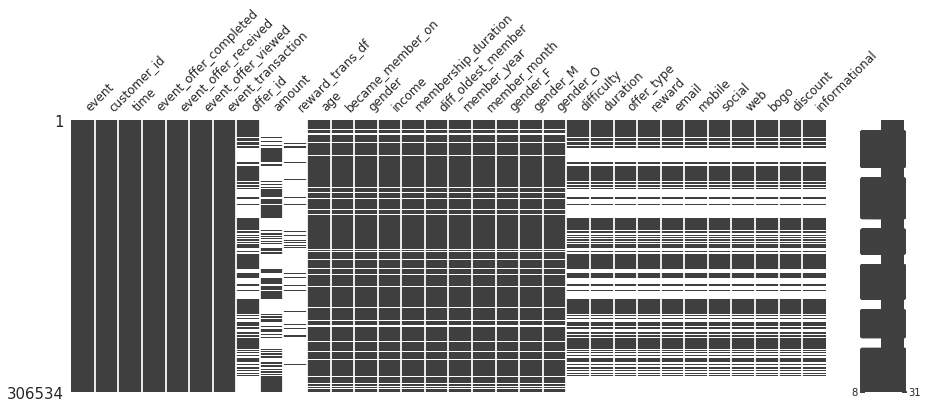

In [49]:
# Heatmap of null values
msno.matrix(final_df, fontsize=12, figsize=(15,5));

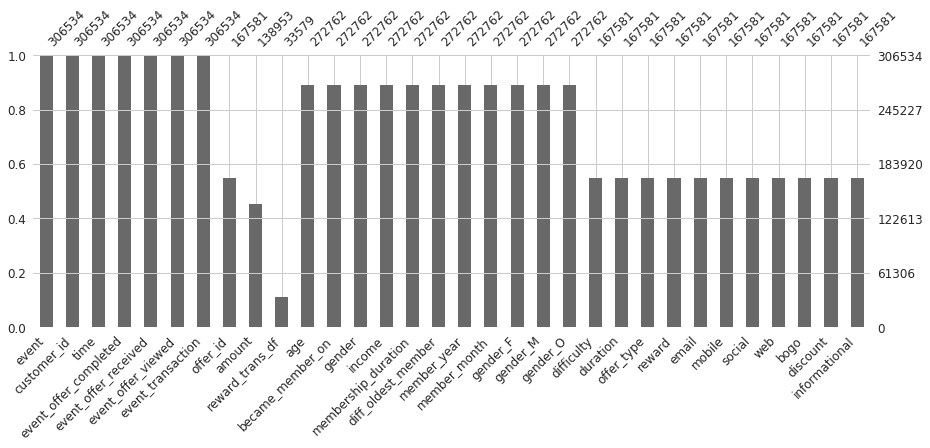

In [50]:
## Percentaje of null values by column

msno.bar(final_df,figsize=(15,5), fontsize=12) 

In [51]:
# The proportion of transactions where the offer_id is null is the same as the transactions with the event='transaction'
final_df[final_df['offer_id'].isna()==True]['event'].value_counts()/len(final_df)

transaction    0.453304
Name: event, dtype: float64

It is important to notice that the 45.33% of null values in the column offer_id, means that the 45.33% of customers didn't receive any offer in anycase they will buy a product and generates a purchase.
- Something that could be interesting is identify what are the demographic caracteristics of this kind of customers because we know that they will made a purchase anyway without receiving any offer

In [52]:
# As these groups of transacctions where a direct purchase, we can have a profile of these customers.  
final_df[final_df['offer_id'].isna()==False].head()

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_trans_df,age,became_member_on,gender,income,membership_duration,diff_oldest_member,member_year,member_month,gender_F,gender_M,gender_O,difficulty,duration,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,75.0,2017-05-09,F,100000.0,2476.0,1380 days,2017.0,5.0,1.0,0.0,0.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,offer_received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,68.0,2018-04-26,M,70000.0,2124.0,1732 days,2018.0,4.0,0.0,1.0,0.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [53]:
# Creating a variable that consider the hours in days
final_df['time_days'] = final_df['time']/24

In [54]:
# dropping duplicate values 
final_df.drop_duplicates(keep=False, inplace=True) 

## Data visualization

In [55]:
final_df.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer_completed  bogo             15333
                 discount         17453
offer_received   bogo             30499
                 discount         30543
                 informational    15235
offer_viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

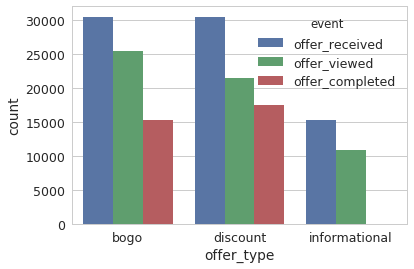

In [56]:
sns.countplot(data=final_df[final_df['event']!='transaction'],x='offer_type',hue='event');


In [57]:
final_df.groupby(['gender', 'event'])['offer_type'].count()

gender  event          
F       offer_completed    15156
        offer_received     27456
        offer_viewed       20786
        transaction            0
M       offer_completed    16052
        offer_received     38129
        offer_viewed       28301
        transaction            0
O       offer_completed      489
        offer_received       916
        offer_viewed         773
        transaction            0
Name: offer_type, dtype: int64

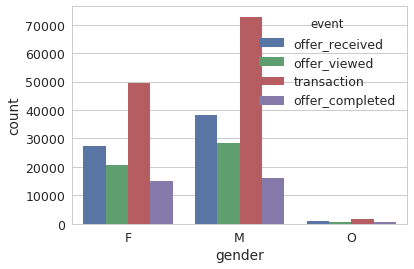

In [58]:
sns.countplot(data=final_df,x='gender',hue='event');

In [68]:
final_df.groupby('gender')['amount']

Text(0,0.5,'$')

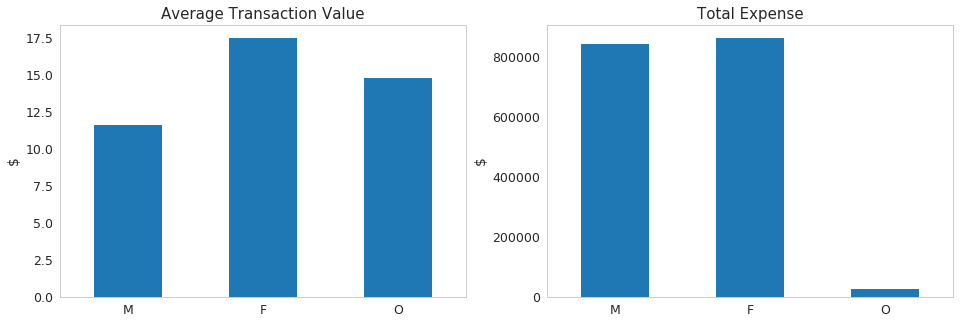

In [69]:
plt.figure(figsize=(16,5)) #figsize=(20,4)

plt.subplot(121)
gender_groupby = final_df.groupby('gender')
#gender_transacts = gender_groupby.amount.sum().sum()
gender_expense = gender_groupby.amount.sum()
(gender_groupby.amount.mean()).reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:blue');
plt.title('Average Transaction Value');
plt.xlabel('');
plt.grid();
plt.ylabel('$')

plt.subplot(122)
gender_expense.reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:blue');
plt.title('Total Expense');
plt.xlabel('');
plt.grid();
plt.ylabel('$')

By gender, women make more expensive transactions and spend more money in general. Men spent the least in both metrics.

## Feature engineering 

To provide the model with sufficient data and achieve accurate results, the current dataset requires more than basic cleaning. While basic cleaning has been performed, additional steps are needed to optimize the data for model input.

To enhance the dataset, I will introduce a separate column to categorize outcomes in the data as either successful or unsuccessful cases. This distinction is particularly relevant for BOGO and discount offers, as they involve 'offer completed' events, unlike informational offers. Therefore, I'll preprocess the data separately for BOGO and discount offers.

For both BOGO and discount offers, there are distinct event paths:

1. **Successful Offer:**
   - Offer received → Offer viewed → Transaction(s) → Offer completed

2. **Ineffective Offer:**
   - Offer received → Offer viewed

3. **Unviewed Offer:**
   - Offer received

4. **Unviewed Success:**
   - Offer received → Transaction(s) → Offer completed

The desired outcome is a successful offer, representing cases where customers viewed the offer and completed the transaction(s). Ineffective and unviewed offers indicate failure, as they did not lead to transactions. It's crucial to differentiate unviewed success cases, where customers completed the offer without viewing it. This distinction is vital for targeting the right customers effectively.

Starbucks ideally wants to target customer groups following the successful offer path (event path 1) while avoiding those likely to follow paths 2 and 3, as they are less likely to make transactions. Moreover, targeting customers following path 4 is not beneficial, as they make transactions regardless, and offering them discounts or BOGO deals would result in a financial loss for Starbucks.

In [ ]:
model_data = Create_Labels(profile, portfolio, transcript_clean)

In [ ]:
model_data.to_csv('model_data_prepared.csv', index=False)

I am planning to have a separate dataframe which has details about customer id and Amount spent by each customer. I am calling that dataframe moneyspent.

Gasto total de de los usuarios. Unificar las bases de datos 

Analisis segun el tipo de oferta y gasto de los usuarios 

# Model

In [80]:
data = pd.read_csv('model_data_prepared.csv')

In [81]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in data.columns if elem not in column_ordering])

data = data[column_ordering]
data = data.drop(columns=['customer_id', 'became_member_on','diff_oldest_member','offer_type','offer_id','gender'])
data.head()

,total_amount,age,bogo,difficulty,discount,duration,email,gender_F,gender_M,gender_O,income,informational,member_month,member_year,membership_duration,mobile,offer_successful,reward,social,time_days,web
0,37.67,75.0,1,5,0,7,1,1.0,0.0,0.0,100000.0,0,5.0,2017.0,2473.0,1,1,5,0,0.0,1
1,49.39,75.0,0,0,0,3,1,1.0,0.0,0.0,100000.0,1,5.0,2017.0,2473.0,1,0,0,1,7.0,0
2,48.28,75.0,1,10,0,7,1,1.0,0.0,0.0,100000.0,0,5.0,2017.0,2473.0,1,1,10,1,17.0,0
3,48.28,75.0,1,5,0,5,1,1.0,0.0,0.0,100000.0,0,5.0,2017.0,2473.0,1,1,5,1,21.0,1
4,1.09,NaN,0,20,1,10,1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0,5,0,0.0,1


In [12]:
data.shape

(76277, 21)

In [82]:
data.dropna(inplace=True)

In [93]:
data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

## Create train and test data sets

In [16]:
# factors/features that influence the label variable
features = data.drop(columns=['offer_successful'])

# label variable to predict
label = data.filter(['offer_successful'])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

# test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

### Evaluate Naive Predictor Performance

In [17]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


## Construct Logistic Regression Model

In [18]:
scorer = make_scorer(fbeta_score, beta=0.5)

# instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# fit train data to the model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total= 2.5min
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.5s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.6s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   2.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................................ penalty=l1, C=1.0, total= 2.6min
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=6, n_jobs=3,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [22]:
import re
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [23]:
# evaluate logistic regression model's performance
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.712
LogisticRegression model f1-score: 0.706


(0.71155746509129969, 0.70559343960356957)

#### Results
- Results suggest that a logistic regression model's accuracy and f1-score is better than the naive predictor
- Accuracy:  Naive predictor: 0.471 vs Logistic regression: 0.712
- F1-score: Naive predictor: 0.640 vs Logistic regression: 0.706


### Evaluate Test Data Performance


In [24]:
evaluate_model_performance(lr_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.712
RandomizedSearchCV model f1-score: 0.707


(0.71194426344544137, 0.70674082767770585)

## Construct Random Forest Classifier Model

In [25]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.6min


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   3.9s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.5s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.4s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.3s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  18.4s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  9.5min


[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   6.6s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.3s
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.1s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 18.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [26]:
# evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.767
RandomForestClassifier model f1-score: 0.753


(0.76721804511278191, 0.75336853605243992)

- Results
- Results suggest that a random forest model's accuracy and f1-score is better than the naive predictor
- Accuracy: Naive predictor: 0.471 vs Random forest: 0.767
- F1-score: Naive predictor: 0.640 vs Random forest: 0.753

### Evaluate Test Data Performance

In [28]:
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.742
RandomForestClassifier model f1-score: 0.728


(0.74241892636960549, 0.72802328658375237)

## Conclusion

In this project, my goal was to predict offer success based on the available offer and customer information. I have built a simple classification model using a naive predictor,Logistic regression, Random Forest Classifier and found out RFC works for this case. <br>

The Random Forest Classifier model can be used to predict whether an offer is going to be successfully completed based on customer and offer characteristics. The final model has an accuracy of 74%, which is a decent number for business purposes, although there is certainly room for improvement. <br>

The most relevant factors for offer success based on the model are:

1. Membership duration
2. Income
3. Age
4. offer Duration

__Who spends more money? male or female?__
And by graph data we can say that Female spend more money, and that can help in targeting customers for starbucks

__Which offer is the most successful?__
Discount offer is more successful because not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. However, BOGO offer has a much greater chance to be viewed or seen by customers. But turning offer received to offer completed can be done by discount offer than bogo offer.

### Improvement/Future scope include:

Explore better modeling techniques and algorithms to see whether model performance can be improved in this way.
Do not drop the observations with missing values, but use some kind of imputation strategy to see whether the model can be improved this way.